In [1]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

import networkx as nx
from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

## Loading the CORA network data

In [2]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, _ = dataset.load(subject_as_feature=True)

In [3]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [4]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 542 positive and 542 negative edges. **


In [5]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 488 positive and 488 negative edges. **


In [6]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 4399

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4399]
        Weights: all 1 (default)
        Features: none


In [7]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 4887

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4887]
        Weights: all 1 (default)
        Features: none


In [8]:
# parameters definition

batch_size = 20
epochs = 20

num_samples = [20, 10]

In [9]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

In [10]:
test_gen = GraphSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [11]:
layer_sizes = [20, 20]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
)

In [12]:
# Build the model and expose input and output sockets of graphsage model
# for link prediction
x_inp, x_out = graphsage.in_out_tensors()

C:\Users\olivi\anaconda3\envs\Py_env\lib\site-packages\keras\initializers\initializers_v2.py:121: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


In [13]:
prediction = link_classification(
    output_dim=1, output_act="relu", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


## Stack the GraphSAGE and prediction layers into a Keras model, and specify the loss

In [14]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=["acc"],
)

## Evaluate the initial (untrained) model on the train and test set

In [15]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

55/55 [==============================] - 4s 72ms/step - loss: 1.0144 - acc: 0.6384

Train Set Metrics of the initial (untrained) model:
	loss: 0.9853
	acc: 0.5953

Test Set Metrics of the initial (untrained) model:
	loss: 1.0144
	acc: 0.6384


## Train the model

In [16]:
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow, verbose=2)

Epoch 1/20
49/49 - 14s - loss: 0.7598 - acc: 0.6025 - val_loss: 0.6137 - val_acc: 0.6356 - 14s/epoch - 289ms/step
Epoch 2/20
49/49 - 13s - loss: 0.5432 - acc: 0.7469 - val_loss: 0.5078 - val_acc: 0.7666 - 13s/epoch - 262ms/step
Epoch 3/20
49/49 - 14s - loss: 0.4381 - acc: 0.8258 - val_loss: 0.4498 - val_acc: 0.8026 - 14s/epoch - 286ms/step
Epoch 4/20
49/49 - 15s - loss: 0.3608 - acc: 0.8668 - val_loss: 0.4216 - val_acc: 0.8137 - 15s/epoch - 301ms/step
Epoch 5/20
49/49 - 14s - loss: 0.3178 - acc: 0.9129 - val_loss: 0.4299 - val_acc: 0.8284 - 14s/epoch - 277ms/step
Epoch 6/20
49/49 - 13s - loss: 0.2834 - acc: 0.9150 - val_loss: 0.4406 - val_acc: 0.8266 - 13s/epoch - 267ms/step
Epoch 7/20
49/49 - 14s - loss: 0.2734 - acc: 0.9385 - val_loss: 0.4427 - val_acc: 0.8303 - 14s/epoch - 285ms/step
Epoch 8/20
49/49 - 15s - loss: 0.2267 - acc: 0.9611 - val_loss: 0.4200 - val_acc: 0.8266 - 15s/epoch - 306ms/step
Epoch 9/20
49/49 - 15s - loss: 0.2293 - acc: 0.9570 - val_loss: 0.4257 - val_acc: 0.8275

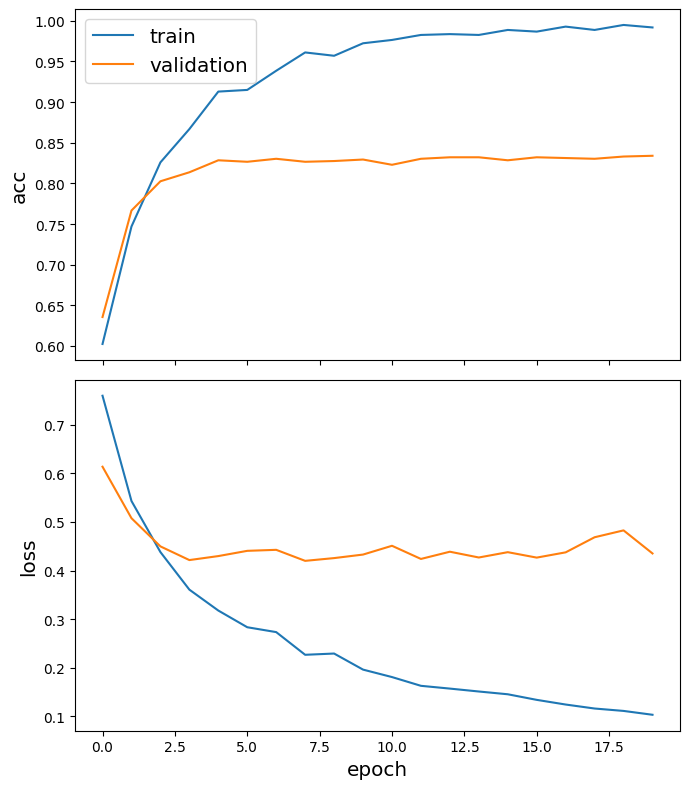

In [17]:
sg.utils.plot_history(history)

## Evaluate the trained model on test citation links

In [18]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

55/55 [==============================] - 4s 69ms/step - loss: 0.4574 - acc: 0.8275

Train Set Metrics of the trained model:
	loss: 0.0630
	acc: 0.9949

Test Set Metrics of the trained model:
	loss: 0.4574
	acc: 0.8275
